# [GD8]-프로젝트-개선된 U-Net 모델 만들기

* 참고(U-Net++ 저자 블로그) : https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20  
* UNet++: A Nested U-Net Architecture for Medical Image Segmentation : https://arxiv.org/pdf/1807.10165.pdf

### Step 1. KITTI 데이터셋 수집과 구축  
다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

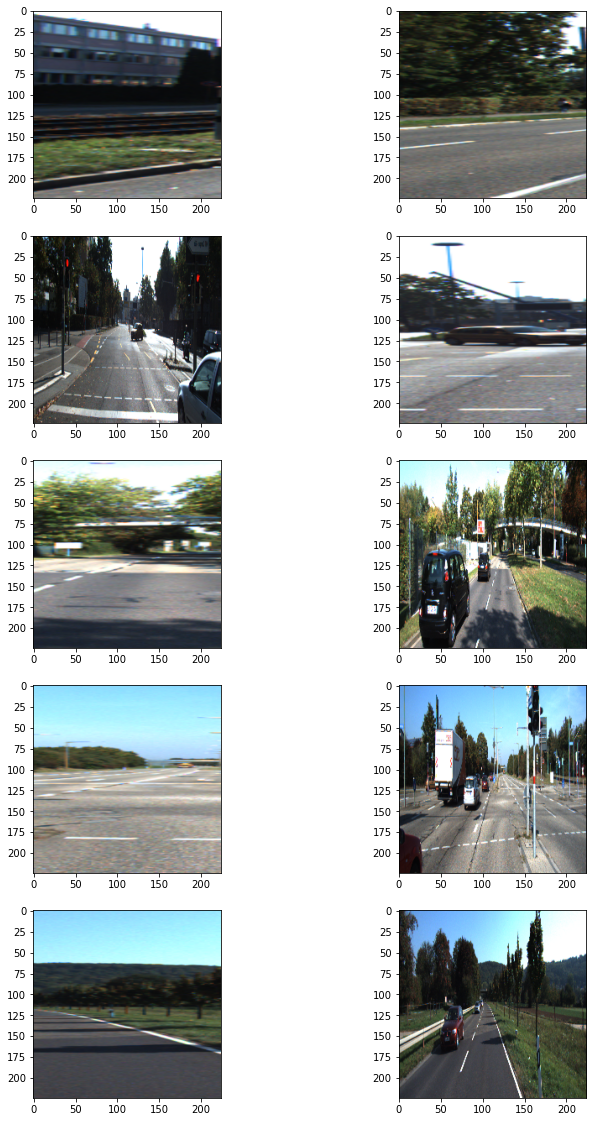

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                dir_path,
                batch_size = 4,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        #load_dataset()을 통해서 kitti dataset의 directory path에서
        #라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        if self.is_train:
            return data[:-30]
        return data[-30:]
    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)
    def __getitem__(self, index):
        #입력과 출력을 만든다.
        #입력은 resize 및 augmentation이 적용된 input image이고
        #출력은 semantic label이다.
        batch_data = self.data[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        #data에서 배치만큼 가져온 것 (input과 label image가 같이 들어있다)
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
    def on_epoch_end(self):
        #한 에폭이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용하는
        #것을 볼수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,
                                augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,
                                augmentation=test_preproc,
                                is_train=False
                               )

### Step 2. U-Net++ 모델의 구현  
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.  
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.  
  
* 참고 : https://engineer-mole.tistory.com/40
* (cf) U-Net++를 Tensorflow로 구현한 github : https://github.com/CarryHJR/Nested-UNet
* https://jinglescode.github.io/2019/12/02/biomedical-image-segmentation-u-net-nested/

#### 모델 구조 만들기

In [ ]:
# import torch
# import torch.nn as nn

# class conv_block_nested(nn.Module):

#     def __init__(self, in_ch, mid_ch, out_ch):
#         super(conv_block_nested, self).__init__()
#         self.activation = nn.ReLU(inplace=True)
#         self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
#         self.bn1 = nn.BatchNorm2d(mid_ch)
#         self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
#         self.bn2 = nn.BatchNorm2d(out_ch)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.activation(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         output = self.activation(x)

#         return output

# class Nested_UNet(nn.Module):

#     def __init__(self, in_ch=3, out_ch=1):
#         super(Nested_UNet, self).__init__()

#         n1 = 64
#         filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
#         self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
#         self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
#         self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
#         self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

#         self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
#         self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
#         self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
#         self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

#         self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
#         self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
#         self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

#         self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
#         self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

#         self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

#         self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

#     def forward(self, x):

#         x0_0 = self.conv0_0(x)
#         x1_0 = self.conv1_0(self.pool(x0_0))
#         x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

#         x2_0 = self.conv2_0(self.pool(x1_0))
#         x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
#         x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

#         x3_0 = self.conv3_0(self.pool(x2_0))
#         x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
#         x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
#         x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

#         x4_0 = self.conv4_0(self.pool(x3_0))
#         x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
#         x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
#         x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
#         x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

#         output = self.final(x0_4)
#         return output

In [6]:
def build_NestedUNet_model(input_shape=(224, 224, 3)):
    
    m = 64
    filters = [m, m*2, m*4, m*8, m*16]
    
    inputs = Input(input_shape)
    
# Left Backbone CONV X0,0
    conv0_0_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn0_0_1 = BatchNormalization()(conv0_0_1)
    act0_0_1 = Activation('relu')(bn0_0_1)
    
    conv0_0_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act0_0_1)
    bn0_0_2 = BatchNormalization()(conv0_0_2)
    conv0_0 = Activation('relu')(bn0_0_2)
    
# Left Backbone CONV X1,0
    conv0_0_D = MaxPooling2D(strides=2)(conv0_0) # 내려가는(Down) 부분 D로 표기
    
    conv1_0_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv0_0_D)
    bn1_0_1 = BatchNormalization()(conv1_0_1)
    act1_0_1 = Activation('relu')(bn1_0_1)
    
    conv1_0_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act1_0_1)
    bn1_0_2 = BatchNormalization()(conv1_0_2)
    conv1_0 = Activation('relu')(bn1_0_2)
    
# Left Backbone CONV X2,0
    conv1_0_D = MaxPooling2D(strides=2)(conv1_0)  # 내려가는 부분 D로 표기
    
    conv2_0_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv1_0_D)
    bn2_0_1 = BatchNormalization()(conv2_0_1)
    act2_0_1 = Activation('relu')(bn2_0_1)
    
    conv2_0_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act2_0_1)
    bn2_0_2 = BatchNormalization()(conv2_0_2)
    conv2_0 = Activation('relu')(bn2_0_2)
    
# Left Backbone CONV X3,0
    conv2_0_D = MaxPooling2D(strides=2)(conv2_0)  # 내려가는 부분 D로 표기
    
    conv3_0_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv2_0_D)
    bn3_0_1 = BatchNormalization()(conv3_0_1)
    act3_0_1 = Activation('relu')(bn3_0_1)
    
    conv3_0_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act3_0_1)
    bn3_0_2 = BatchNormalization()(conv3_0_2)
    conv3_0 = Activation('relu')(bn3_0_2)
    
# Left Backbone CONV X4,0
    conv3_0_D = MaxPooling2D(strides=2)(conv3_0)  # 내려가는 부분 D로 표기
    
    conv4_0_1 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv3_0_D)
    bn4_0_1 = BatchNormalization()(conv4_0_1)
    act4_0_1 = Activation('relu')(bn4_0_1)
    
    conv4_0_2 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act4_0_1)
    bn4_0_2 = BatchNormalization()(conv4_0_2)
    conv4_0 = Activation('relu')(bn4_0_2)  

# The First Middle Connection CONV X0,1
    conv1_0_U = UpSampling2D()(conv1_0)   # 올라가는(Up) 부분 U로 표기
    conv0_1_R = Concatenate()([conv0_0, conv1_0_U])  # 오른쪽(Right)으로 가는 부분 R로 표기  
    
    conv0_1_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv0_1_R)
    bn0_1_1 = BatchNormalization()(conv0_1_1)
    act0_1_1 = Activation('relu')(bn0_1_1)
    
    conv0_1_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act0_1_1)
    bn0_1_2 = BatchNormalization()(conv0_1_2)
    conv0_1 = Activation('relu')(bn0_1_2)
    
# The First Middle Connection CONV X1,1
    conv2_0_U = UpSampling2D()(conv2_0)   # 올라가는 부분 U로 표기
    conv1_1_R = Concatenate()([conv1_0, conv2_0_U])  # 오른쪽으로 가는 부분 R로 표기
    
    conv1_1_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv1_1_R)
    bn1_1_1 = BatchNormalization()(conv1_1_1)
    act1_1_1 = Activation('relu')(bn1_1_1)
    
    conv1_1_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act1_1_1)
    bn1_1_2 = BatchNormalization()(conv1_1_2)
    conv1_1 = Activation('relu')(bn1_1_2)
    
# The First Middle Connection CONV X2,1
    conv3_0_U = UpSampling2D()(conv3_0)   # 올라가는 부분 U로 표기
    conv2_1_R = Concatenate()([conv2_0, conv3_0_U])   # 오른쪽으로 가는 부분 R로 표기
    
    conv2_1_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv2_1_R)
    bn2_1_1 = BatchNormalization()(conv2_1_1)
    act2_1_1 = Activation('relu')(bn2_1_1)
    
    conv2_1_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act2_1_1)
    bn2_1_2 = BatchNormalization()(conv2_1_2)
    conv2_1 = Activation('relu')(bn2_1_2)
    
# Right Backbone CONV X3,1
    conv4_0_U = UpSampling2D()(conv4_0)   # 올라가는 부분 UP으로 표기
    conv3_1_R = Concatenate()([conv3_0, conv4_0_U])   # 오른쪽으로 가는 부분 Right으로 표기 
    conv3_1_1 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv3_1_R)
    bn3_1_1 = BatchNormalization()(conv3_1_1)
    act3_1_1 = Activation('relu')(bn3_1_1)
    conv3_1_2 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act3_1_1)
    bn3_1_2 = BatchNormalization()(conv3_1_2)
    conv3_1 = Activation('relu')(bn3_1_2)
    
# The Second Middle Connection CONV X0,2    
    conv1_1_U = UpSampling2D()(conv1_1)   # 올라가는 부분 U로 표기
    conv0_2_R = Concatenate()([conv0_0, conv0_1, conv1_1_U])   # 오른쪽으로 가는 부분 R로 표기
    
    conv0_2_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv0_2_R)
    bn0_2_1 = BatchNormalization()(conv0_2_1)
    act0_2_1 = Activation('relu')(bn0_2_1)
    
    conv0_2_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act0_2_1)
    bn0_2_2 = BatchNormalization()(conv0_2_2)
    conv0_2 = Activation('relu')(bn0_2_2)
    
# The Second Middle Connection CONV X1,2
    conv2_1_U = UpSampling2D()(conv2_1)   # 올라가는 부분 U로 표기
    conv1_2_R = Concatenate()([conv1_0, conv1_1, conv2_1_U])   # 오른쪽으로 가는 부분 R로 표기
    
    conv1_2_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv1_2_R)
    bn1_2_1 = BatchNormalization()(conv1_2_1)
    act1_2_1 = Activation('relu')(bn1_2_1)
    
    conv1_2_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act1_2_1)
    bn1_2_2 = BatchNormalization()(conv1_2_2)
    conv1_2 = Activation('relu')(bn1_2_2)
    
# Right Backbone CONV X2,2
    conv3_1_U = UpSampling2D()(conv3_1)   # 올라가는 부분 U로 표기
    conv2_2_R = Concatenate()([conv2_0, conv2_1, conv3_1_U])   # 오른쪽으로 가는 부분 R로 표기
    
    conv2_2_1 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv2_2_R)
    bn2_2_1 = BatchNormalization()(conv2_2_1)
    act2_2_1 = Activation('relu')(bn2_2_1)
    
    conv2_2_2 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act2_2_1)
    bn2_2_2 = BatchNormalization()(conv2_2_2)
    conv2_2 = Activation('relu')(bn2_2_2)
    
# The Third Middle Connection CONV X0,3
    conv1_2_U = UpSampling2D()(conv1_2)   # 올라가는 부분 U로 표기
    conv0_3_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv1_2_U])  # 오른쪽으로 가는 부분 R로 표기
    
    conv0_3_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv0_3_R)
    bn0_3_1 = BatchNormalization()(conv0_3_1)
    act0_3_1 = Activation('relu')(bn0_3_1)
    
    conv0_3_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act0_3_1)
    bn0_3_2 = BatchNormalization()(conv0_3_2)
    conv0_3 = Activation('relu')(bn0_3_2)
    
# Right Backbone CONV X1,3
    conv2_2_U = UpSampling2D()(conv2_2)   # 올라가는 부분 U로 표기
    conv1_3_R = Concatenate()([conv1_0, conv1_1, conv1_2, conv2_2_U])  # 오른쪽으로 가는 부분 R로 표기
    
    conv1_3_1 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv1_3_R)
    bn1_3_1 = BatchNormalization()(conv1_3_1)
    act1_3_1 = Activation('relu')(bn1_3_1)
    
    conv1_3_2 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act1_3_1)
    bn1_3_2 = BatchNormalization()(conv1_3_2)
    conv1_3 = Activation('relu')(bn1_3_2)
    
# Right Backbone CONV X0,4
    conv1_3_U = UpSampling2D()(conv1_3)  # 올라가는 부분 U로 표기                                      
    conv0_4_R = Concatenate()([conv0_0, conv0_1, conv0_2, conv0_3, conv1_3_U])  # 오른쪽으로 가는 부분 R로 표기
    
    conv0_4_1 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv0_4_R)
    bn0_4_1 = BatchNormalization()(conv0_4_1)
    act0_4_1 = Activation('relu')(bn0_4_1)
    
    conv0_4_2 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act0_4_1)
    bn0_4_2 = BatchNormalization()(conv0_4_2)
    conv0_4 = Activation('relu')(bn0_4_2)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv0_4)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [7]:
model = build_NestedUNet_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

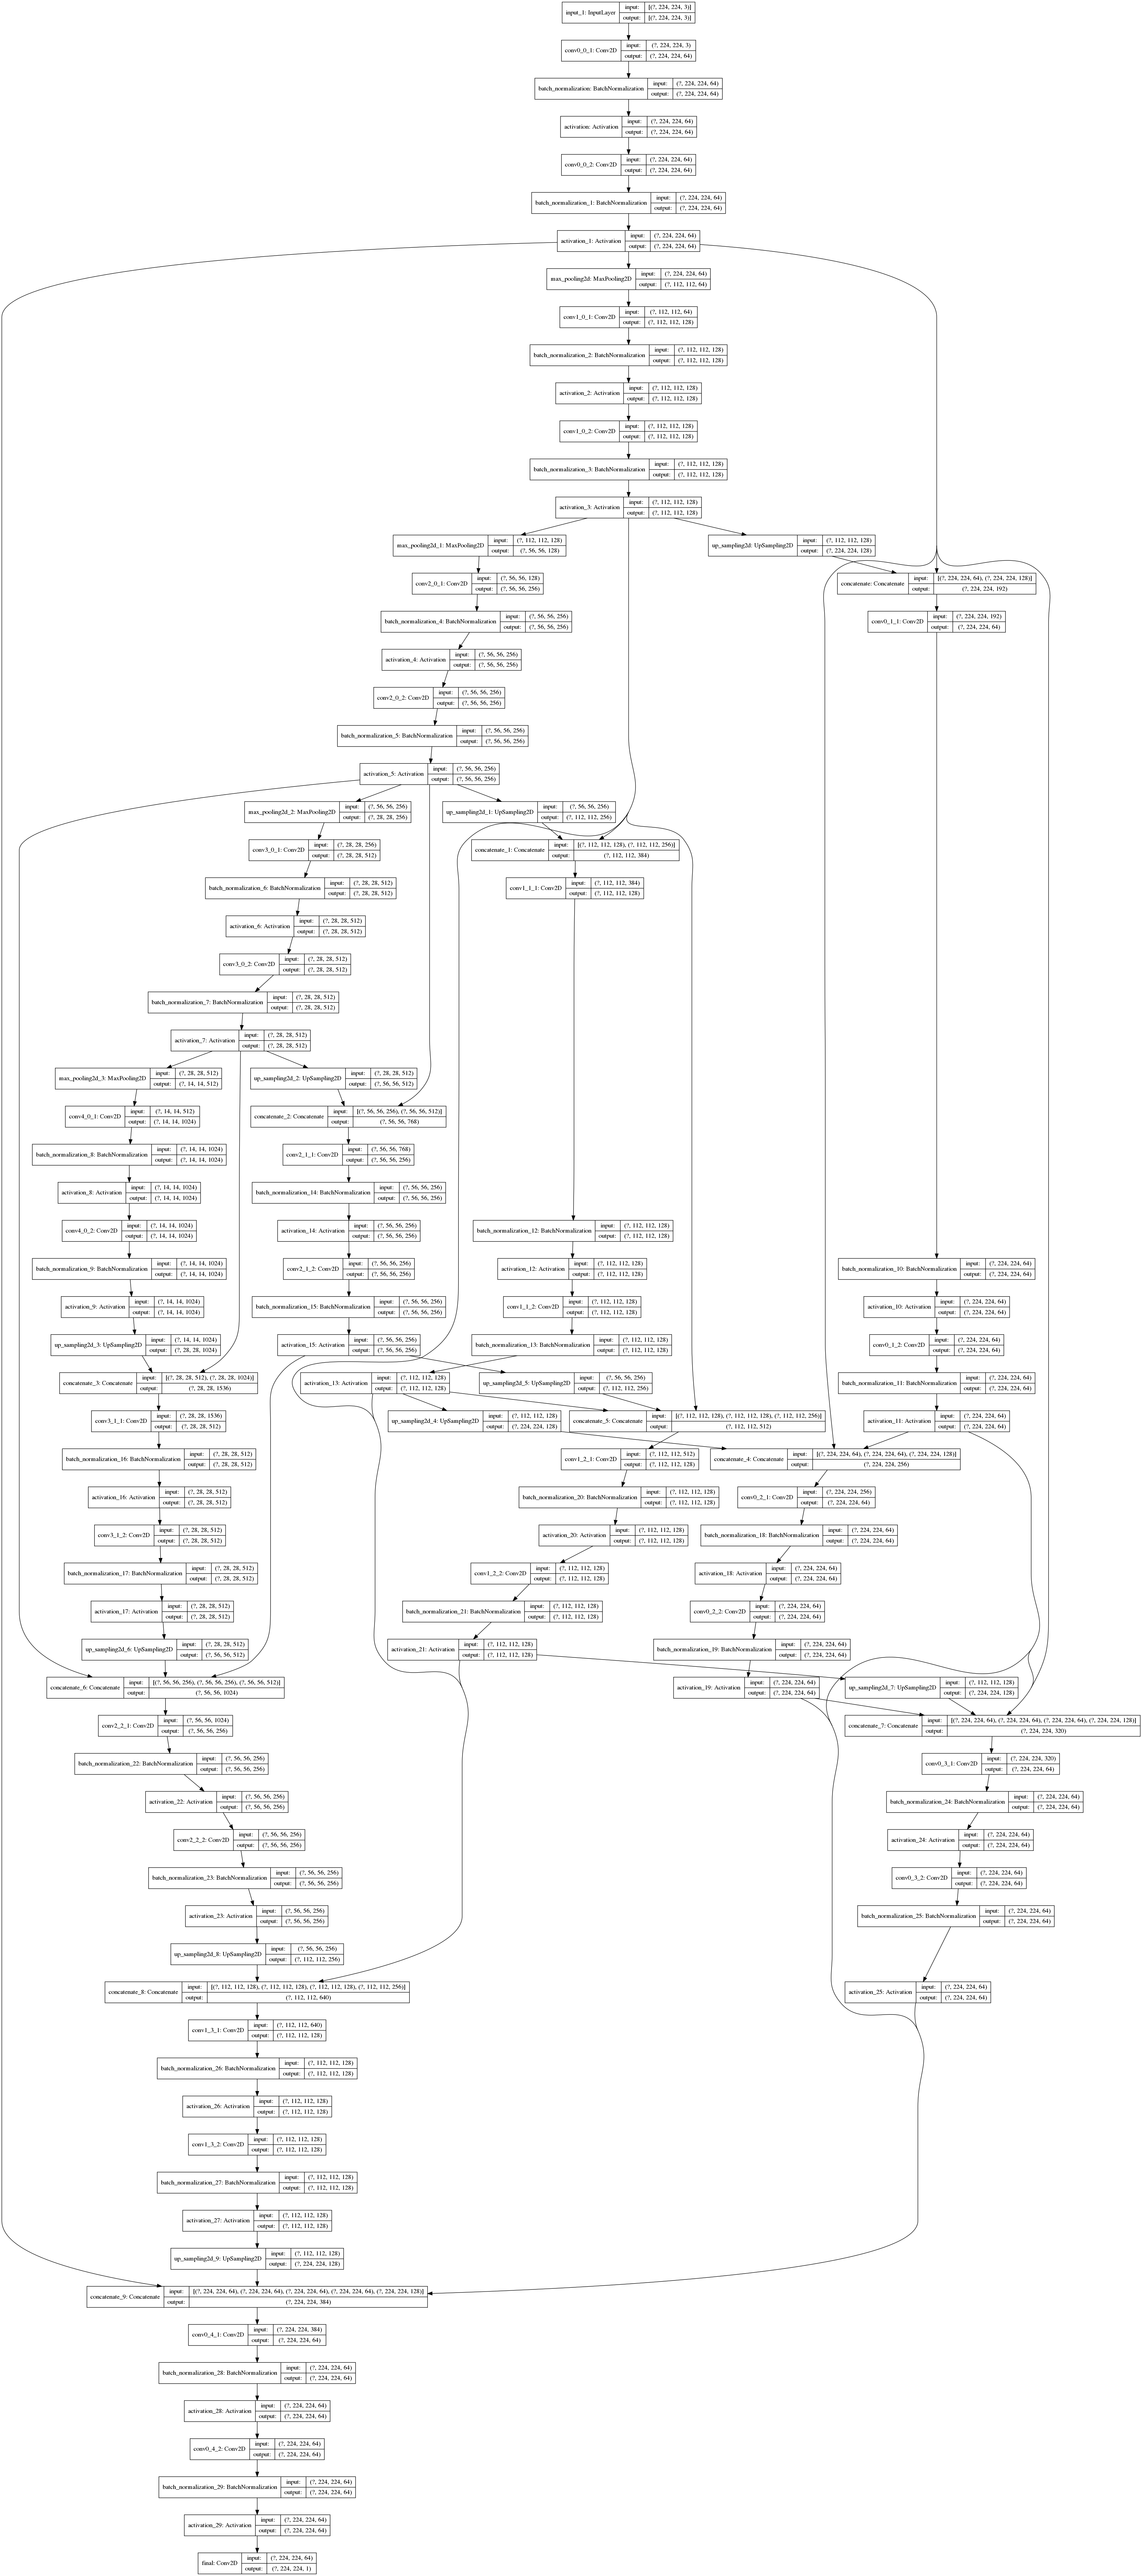

In [8]:
tf.keras.utils.plot_model(model, './NestedUNet.png', show_shapes=True)

#### 모델 학습하기

In [9]:
model = build_NestedUNet_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_NestedUNet_unet_100.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 19s 430ms/step - loss: 0.4189 - val_loss: 4.5617
Epoch 2/100
43/43 [==============================] - 19s 437ms/step - loss: 0.2811 - val_loss: 0.9682
Epoch 3/100
43/43 [==============================] - 20s 458ms/step - loss: 0.2932 - val_loss: 1.2527
Epoch 4/100
43/43 [==============================] - 19s 448ms/step - loss: 0.2229 - val_loss: 0.3689
Epoch 5/100
43/43 [==============================] - 20s 461ms/step - loss: 0.2057 - val_loss: 0.3289
Epoch 6/100
43/43 [==============================] - 20s 462ms/step - loss: 0.1828 - val_loss: 0.2159
Epoch 7/100
43/43 [==============================] - 20s 462ms/step - loss: 0.1983 - val_loss: 0.1875
Epoch 8/100
43/43 [==============================] - 20s 464ms/step - loss: 0.2082 - val_loss: 0.2780
Epoch 9/100
43/43 [==============================] - 20s 460ms/step - loss: 0.1990 - val_loss: 0.2155
Epoch 

In [10]:
model2 = build_NestedUNet_model()
model2.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model2.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
 )

Epoch 1/200
43/43 [==============================] - 19s 450ms/step - loss: 0.5232 - val_loss: 2.8392
Epoch 2/200
43/43 [==============================] - 19s 450ms/step - loss: 0.3351 - val_loss: 1.6665
Epoch 3/200
43/43 [==============================] - 19s 446ms/step - loss: 0.2904 - val_loss: 1.0485
Epoch 4/200
43/43 [==============================] - 19s 439ms/step - loss: 0.2657 - val_loss: 0.6251
Epoch 5/200
43/43 [==============================] - 19s 441ms/step - loss: 0.2490 - val_loss: 0.4356
Epoch 6/200
43/43 [==============================] - 20s 454ms/step - loss: 0.2283 - val_loss: 0.4063
Epoch 7/200
43/43 [==============================] - 19s 441ms/step - loss: 0.2174 - val_loss: 0.2526
Epoch 8/200
43/43 [==============================] - 19s 443ms/step - loss: 0.2337 - val_loss: 0.2647
Epoch 9/200
43/43 [==============================] - 20s 466ms/step - loss: 0.1889 - val_loss: 0.2137
Epoch 10/200
43/43 [==============================] - 19s 448ms/step - loss: 0.190

43/43 [==============================] - 20s 473ms/step - loss: 0.0641 - val_loss: 0.1580
Epoch 158/200
43/43 [==============================] - 21s 481ms/step - loss: 0.0653 - val_loss: 0.1966
Epoch 159/200
43/43 [==============================] - 21s 478ms/step - loss: 0.0634 - val_loss: 0.1997
Epoch 160/200
43/43 [==============================] - 21s 480ms/step - loss: 0.0697 - val_loss: 0.1875
Epoch 161/200
43/43 [==============================] - 20s 456ms/step - loss: 0.0572 - val_loss: 0.1634
Epoch 162/200
43/43 [==============================] - 21s 488ms/step - loss: 0.0799 - val_loss: 0.2005
Epoch 163/200
43/43 [==============================] - 21s 494ms/step - loss: 0.0538 - val_loss: 0.1347
Epoch 164/200
43/43 [==============================] - 21s 493ms/step - loss: 0.0519 - val_loss: 0.1312
Epoch 165/200
43/43 [==============================] - 21s 481ms/step - loss: 0.0471 - val_loss: 0.1393
Epoch 166/200
43/43 [==============================] - 21s 482ms/step - loss: 

In [11]:
model2_path = dir_path + '/seg_model_NestedUNet_unet_200.h5'
model2.save(model2_path)  #학습한 모델을 저장해 주세요.

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석  
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

#### U-Net++  100 epoch (model 1) 시각화

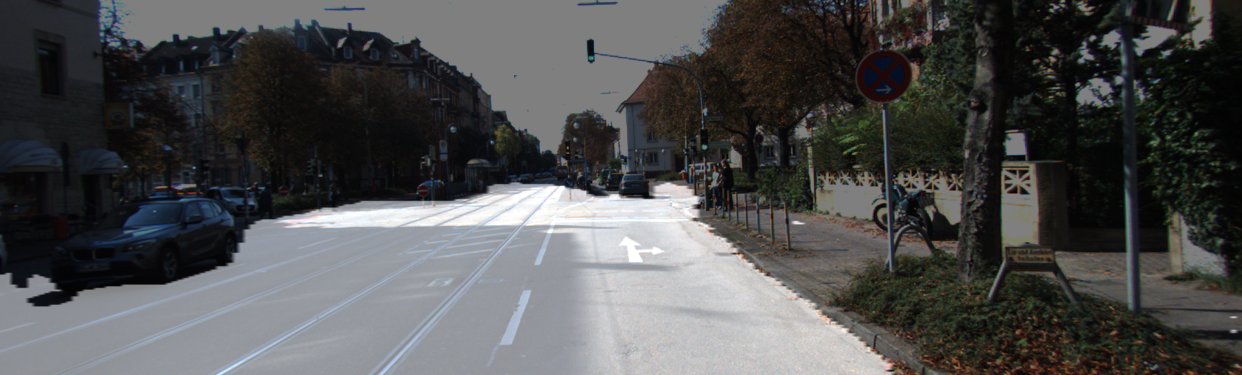

In [12]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.947851


0.9478506528212568

#### U-Net++  200 epoch (model 2) 시각화

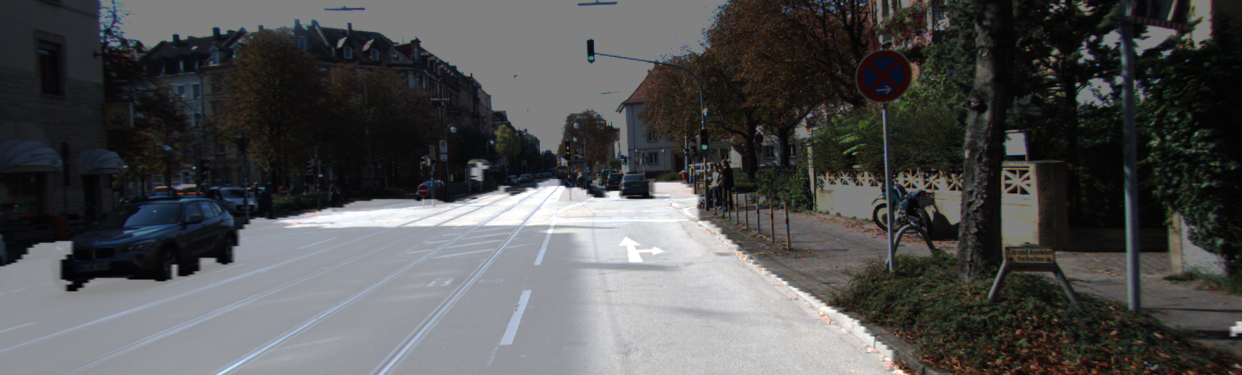

In [16]:
def get_output(model2, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model2(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [17]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [18]:
def get_output(model2, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model2(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.935300


0.9352997850737419